<a href="https://colab.research.google.com/github/alicepearse/DL_prac/blob/master/LSTM_non_linear_sequence_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
# Make the data
series = np.sin((0.1*np.arange(400))**2)

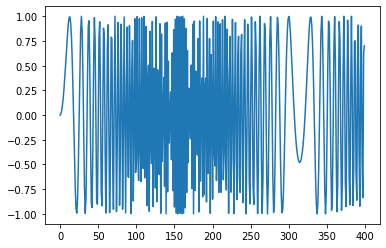

In [55]:
# Plot the data
plt.plot(series)

In [56]:
# Build the dataset
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10, 1) Y.shape (390, 1)


In [57]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [58]:
# Define RNN
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.L = n_rnnlayers
    self.K = n_outputs

    self.rnn = nn.LSTM(
        input_size = self.D,
        hidden_size = self.M,
        num_layers = self.L,
        batch_first = True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, _ = self.rnn(X, (h0, c0))

    out = self.fc(out[:, -1, :])
    return out

In [59]:
# Instantiate the model
model = RNN(n_inputs=1, n_hidden=10, n_rnnlayers=1, n_outputs=1)
model.to(device)

RNN(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [60]:
# Loss and optimize
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [61]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [62]:
# Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):
  
  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward Pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test losses
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it+1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
  return train_losses, test_losses

In [63]:
# Move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [64]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.5096, Test Loss: 0.5455
Epoch 10/200, Train Loss: 0.4951, Test Loss: 0.6636
Epoch 15/200, Train Loss: 0.4726, Test Loss: 0.5880
Epoch 20/200, Train Loss: 0.4214, Test Loss: 0.5530
Epoch 25/200, Train Loss: 0.3527, Test Loss: 0.5167
Epoch 30/200, Train Loss: 0.2640, Test Loss: 0.4908
Epoch 35/200, Train Loss: 0.1791, Test Loss: 0.3608
Epoch 40/200, Train Loss: 0.1080, Test Loss: 0.2233
Epoch 45/200, Train Loss: 0.0639, Test Loss: 0.1746
Epoch 50/200, Train Loss: 0.0430, Test Loss: 0.1196
Epoch 55/200, Train Loss: 0.0223, Test Loss: 0.0857
Epoch 60/200, Train Loss: 0.0163, Test Loss: 0.0893
Epoch 65/200, Train Loss: 0.0113, Test Loss: 0.0692
Epoch 70/200, Train Loss: 0.0090, Test Loss: 0.0666
Epoch 75/200, Train Loss: 0.0075, Test Loss: 0.0594
Epoch 80/200, Train Loss: 0.0061, Test Loss: 0.0638
Epoch 85/200, Train Loss: 0.0052, Test Loss: 0.0599
Epoch 90/200, Train Loss: 0.0045, Test Loss: 0.0610
Epoch 95/200, Train Loss: 0.0038, Test Loss: 0.0588
Epoch 100/200

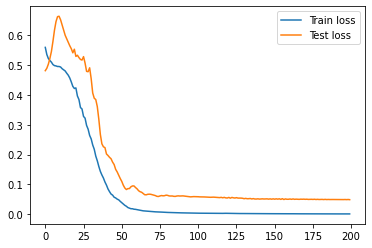

In [65]:
# Plot losses
plt.plot(train_losses, label = 'Train loss')
plt.plot(test_losses, label='Test loss')
plt.legend()


In [66]:
# One step forecasting
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].reshape(1, T, 1)
  p = model(input_)[0,0].item()
  i += 1

  # update the prediction list
  validation_predictions.append(p)

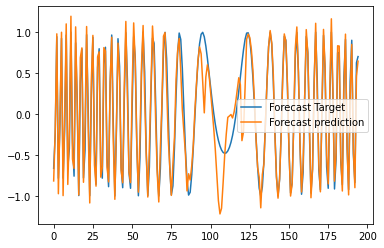

In [67]:
plt.plot(validation_target, label = 'Forecast Target')
plt.plot(validation_predictions, label = 'Forecast prediction')
plt.legend()

In [74]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)

  validation_predictions.append(p[0,0].item())

  last_x = torch.cat((last_x[1:], p[0]))

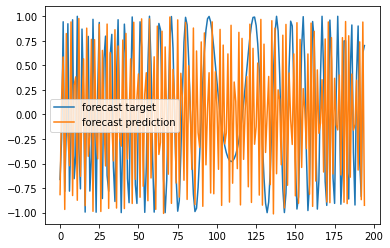

In [75]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()